<a href="https://colab.research.google.com/github/lizardnote/NLP/blob/main/RAG_finetuing_hf_mrc_ko_rag.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install datasets

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from datasets import load_dataset

In [4]:
# ds = load_dataset("iamjoon/klue-mrc-ko-rag-dataset")
import pandas as pd

df = pd.read_parquet("hf://datasets/iamjoon/klue-mrc-ko-rag-dataset/data/train-00000-of-00001.parquet")

In [5]:
df.head()

,question,search_result,answer,extracted_ref_numbers,type,__index_level_0__
0,북태평양 기단과 오호츠크해 기단이 만나 국내에 머무르는 기간은?,[열대우림 '장마전선'은 벵골만과 서북태평양에서 동아시아 몬순의 하위시스템으로 조성...,북태평양 기단과 오호츠크해 기단이 만나 형성되는 장마전선은 한반도에 약 한 달가량 ...,[2],mrc_question,0
1,지능형 생산자동화 기반기술을 개발중인 스타트업은?,[부산시와 (재)부산정보산업진흥원(원장 이인숙)이 ‘2020~2021년 지역SW서비...,지능형 생산자동화 기반기술을 개발 중인 스타트업으로는 삼보테크놀로지가 있습니다. 삼...,[1],mrc_question,1
2,개막전에서 3안타 2실점을 기록해서 패한 선수는?,"[;한큐 - 사카모토 도시조\n* 타석에서의 상황 : 헛스윙, 볼, 헛스윙, 파울,...",개막전에서 3안타 2실점을 기록해서 패한 선수는 사이타마 세이부 라이온스의 와쿠이 ...,[2],mrc_question,2
3,컵라면 매출에서 불닭볶음면을 이긴 상품은?,[유명 맛집 이름을 달고 나온 편의점 자체상표(PB) 라면이 인기를 끌고 있다. ‘...,세븐일레븐에서 판매하는 '교동반점 짬뽕'이 삼양식품의 '불닭볶음면'을 제치고 컵라면...,[1],mrc_question,3
4,정부에게 환경과 관련해서 우선적으로 원조 받고 있는 곳은?,[정부가 전기자동차를 보급하는 방식을 바꾼다. 주로 일반 소비자와 관공서에 판매하던...,정부가 환경과 관련하여 우선적으로 원조를 받고 있는 곳은 주로 전기자동차 보급과 관...,[1],mrc_question,4


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1884 entries, 0 to 1883
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   question               1884 non-null   object
 1   search_result          1884 non-null   object
 2   answer                 1884 non-null   object
 3   extracted_ref_numbers  1884 non-null   object
 4   type                   1884 non-null   object
 5   __index_level_0__      1884 non-null   int64 
dtypes: int64(1), object(5)
memory usage: 88.4+ KB


In [7]:
df['type'].unique()

array(['mrc_question', 'mrc_question_with_1_to_4_negative',
       'synthetic_question', 'paraphrased_question', 'no_answer'],
      dtype=object)

type을 살펴보면 rag에서 발생할 수 있는 다양한 시나리오에 대응하기 위해 만들어진 유형
- mrc_question : 질문이 지엽적인 데이터 유형
- mrc_question_with_1_to_4_negative :
- synthetic_question
- paraphrased_question
- no_answer

In [12]:
print('샘플타입:', df['type'].loc[5])
print('샘플질문:', df['question'].loc[5])

샘플타입: mrc_question
샘플질문: 에티하드 웰니스 프로그램의 일환으로 위생에 관한 정보를 제공하는 것은 누구인가?


In [14]:
print('샘플답변:', df['answer'].loc[5])
print('인용번호:', df['extracted_ref_numbers'].loc[5])

샘플답변: 에티하드 웰니스 프로그램의 일환으로 위생에 관한 정보를 제공하는 사람은 특별 훈련 과정을 거친 에티하드항공의 웰니스 엠버서더입니다. 이들은 여행 전 과정에 걸쳐 조언과 건강 및 위생 조치에 대한 세부 사항을 공유하며 맞춤화된 정보를 제공합니다 [[ref3]].
인용번호: [3]


- 인용번호[3]의 의미는 5개 검색 결과(search_result) 중에서 3번째 문서를 인용했다는 뜻
  - 검색 결과 수(5개)는 mrc_question의 경우 5개로 고정된 값임

- 표시는 [[reg 문서번호]]

In [17]:
df['search_result'].loc[5][2]

'아랍 에미리트의 국영항공사 에티하드항공이 지난 10월 21일 열린 ’2020비즈니스 트래블러 중동 어워드(Business Traveller Middle East Awards 2020)에서 ‘최고의 이코노미 클래스(Best Economy Class)’와 ‘최고의 상용고객 프로그램(Best Frequent Flyer Programme’)’상의 영예를 안았다. 이는 2012년과 2013년에 열린 비즈니스 트래블러 중동 어워드에서 각각 최고의 이코노미 클래스, 최고의 상용 고객프로그램 분야의 첫 수상을 한 이래로 2회째 수상 기록이다. 지난 해, 에티하드항공은 다양한 수상 경력을 지닌 비즈니스, 퍼스트, 더 레지던스 캐빈에서 펼쳐 온 혁신과 마찬가지로 이코노미석에서도 기내식 선택권을 넓히고 무선 기내 엔터테인먼트, 인체공학적 디자인으로 설계된 좌석과 여유로운 레그룸을 가진 이코노미석 도입을 비롯해 옆 좌석 비우기, 보다 넉넉한 이코노미 스페이스 석 선택 옵션, 선호좌석 선택 사항을 제공하는 등 기내 경험에 대한 더욱 다양한 선택권을 제공해 왔다. 이를 통해 승객이 개인의 필요와 요구에 맞는 맞춤화된 선택을 할 수 있도록 돕고 만족도 높은 항공 여행을 할 수 있도록 서비스와 상품 개선에 투자를 지속해 왔다. 또한, 에티하드항공은 항공사의 건강 및 위생 프로그램인 ‘에티하드 웰니스’프로그램을 통해 신종코로나바이러스로 인한 전례 없는 시기에 필수적인 여행을 해야만 하는 여행자들에게 마음의 평화와 여행에 대한 자신감을 심어주기 위해 펼친 다양한 노력이 고객의 긍정적인 평가를 받았다고 전했다. 예약 과정에서부터 공항 이용은 물론 항공여행에 이르기까지 인공지능 기술을 비롯한 최신 기술을 과감히 도입해 광범위한 예방 조치를 시행하고 있으며 업계 최초로 선보인 에티하드 웰니스 프로그램에서는 특별 훈련 과정을 거친 에티하드항공의 웰니스 엠버서더가 여행 전 과정에 걸친 조언과 건강 및 위생 조치에 대한 세부 사항을 공유하며 맞춤화된 정보를 제공한다. 한 해 동안, 에티하드항공은 에티

In [20]:
df['search_result_len'] = df['search_result'].apply(len)  #각 데이터의 검색 결과 개수
df['extracted_ref_len'] = df['extracted_ref_numbers'].apply(len)  #각 데이터가 답변할 때 인용한 문서 개수

In [21]:
df.head()

,question,search_result,answer,extracted_ref_numbers,type,__index_level_0__,search_result_len,extracted_ref_len
0,북태평양 기단과 오호츠크해 기단이 만나 국내에 머무르는 기간은?,[열대우림 '장마전선'은 벵골만과 서북태평양에서 동아시아 몬순의 하위시스템으로 조성...,북태평양 기단과 오호츠크해 기단이 만나 형성되는 장마전선은 한반도에 약 한 달가량 ...,[2],mrc_question,0,5,1
1,지능형 생산자동화 기반기술을 개발중인 스타트업은?,[부산시와 (재)부산정보산업진흥원(원장 이인숙)이 ‘2020~2021년 지역SW서비...,지능형 생산자동화 기반기술을 개발 중인 스타트업으로는 삼보테크놀로지가 있습니다. 삼...,[1],mrc_question,1,5,1
2,개막전에서 3안타 2실점을 기록해서 패한 선수는?,"[;한큐 - 사카모토 도시조\n* 타석에서의 상황 : 헛스윙, 볼, 헛스윙, 파울,...",개막전에서 3안타 2실점을 기록해서 패한 선수는 사이타마 세이부 라이온스의 와쿠이 ...,[2],mrc_question,2,5,1
3,컵라면 매출에서 불닭볶음면을 이긴 상품은?,[유명 맛집 이름을 달고 나온 편의점 자체상표(PB) 라면이 인기를 끌고 있다. ‘...,세븐일레븐에서 판매하는 '교동반점 짬뽕'이 삼양식품의 '불닭볶음면'을 제치고 컵라면...,[1],mrc_question,3,5,1
4,정부에게 환경과 관련해서 우선적으로 원조 받고 있는 곳은?,[정부가 전기자동차를 보급하는 방식을 바꾼다. 주로 일반 소비자와 관공서에 판매하던...,정부가 환경과 관련하여 우선적으로 원조를 받고 있는 곳은 주로 전기자동차 보급과 관...,[1],mrc_question,4,5,1


타입별 검색한 문서 수와 인용한 문서 수 분포 확인

타입: mrc_question
전체 데이터 수: 491개

문서 인용 분포:
1개의 문서를 인용한 샘플: 439개
2개의 문서를 인용한 샘플: 44개
3개의 문서를 인용한 샘플: 7개
4개의 문서를 인용한 샘플: 1개

검색된 문서 분포:
검색 문서로 5개가 존재하는 경우: 491개


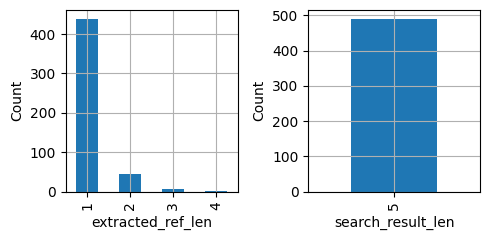

In [31]:
def plot_lengths_by_type(df, plot_type):
    """
    특정 type의 데이터에 대해 extracted_ref_len과 search_result_len의 분포를 시각화하고 값 출력.

    Parameters:
    df (pd.DataFrame): 데이터프레임
    plot_type (str): 시각화할 데이터의 type 값 (예: 'qa', 'summarize' 등)
    """
    # 유효한 type 값인지 검증
    if plot_type not in df['type'].unique():
        print(f"'{plot_type}'는 유효하지 않은 타입입니다. 데이터프레임에 존재하는 타입을 확인하세요.")
        return

    # 해당 type의 데이터만 필터링하고 전체 개수 계산
    df_type = df[df['type'] == plot_type]
    total_count = len(df_type)

    # 길이별 값 계산
    # extracted_ref_len: 실제 인용된 문서의 개수
    # search_result_len: 검색으로 조회된 문서의 개수
    extracted_counts = df_type['extracted_ref_len'].value_counts().sort_index()
    search_counts = df_type['search_result_len'].value_counts().sort_index()

    # 분석 결과 출력
    # 전체 데이터 수와 각 길이별 분포를 출력
    print(f"타입: {plot_type}")
    print(f"전체 데이터 수: {total_count:,}개")
    print("\n문서 인용 분포:")
    for length, count in extracted_counts.items():
        print(f"{length}개의 문서를 인용한 샘플: {count}개")
    print("\n검색된 문서 분포:")
    for length, count in search_counts.items():
        print(f"검색 문서로 {length}개가 존재하는 경우: {count}개")

    # 시각화를 위한 subplot 생성
    # figsize(5, 2.5): 적당한 크기의 그래프를 위한 설정
    fig, axes = plt.subplots(1, 2, figsize=(5, 2.5))

    # 두 그래프 사이의 간격 설정 (타이틀이나 레이블이 겹치지 않도록)
    plt.subplots_adjust(wspace=0.6)

    # 왼쪽 그래프: 인용된 문서 수 분포
    extracted_counts.plot(
        kind='bar',
        ax=axes[0],
        xlabel='extracted_ref_len',  # 인용된 문서의 개수
        ylabel='Count',             # 해당 개수의 출현 빈도
        grid=True                   # 격자 표시
    )

    # 오른쪽 그래프: 검색된 문서 수 분포
    search_counts.plot(
        kind='bar',
        ax=axes[1],
        xlabel='search_result_len',  # 검색된 문서의 개수
        ylabel='Count',             # 해당 개수의 출현 빈도
        grid=True                   # 격자 표시
    )

    # 그래프의 레이아웃 자동 조정
    plt.tight_layout()
    plt.show()

plot_lengths_by_type(df, 'mrc_question')


- mrc_question 타입은 모든 데이터가 5개로 동일하며 이 중 439개 데이터가 1개를 인용한다
- 그 외 44개, 7개, 1개는 각각 2,3,4개 데이터를 인용하고 5개 모두 인용하는 데이터는 없음
- 지엽적으로 질문하는 타입이라 다수의 문서보단 1개 문서로 대답하는 경우가 많은 것

타입: mrc_question_with_1_to_4_negative
전체 데이터 수: 296개

문서 인용 분포:
1개의 문서를 인용한 샘플: 282개
2개의 문서를 인용한 샘플: 12개
3개의 문서를 인용한 샘플: 1개
4개의 문서를 인용한 샘플: 1개

검색된 문서 분포:
검색 문서로 1개가 존재하는 경우: 80개
검색 문서로 2개가 존재하는 경우: 75개
검색 문서로 3개가 존재하는 경우: 59개
검색 문서로 4개가 존재하는 경우: 82개


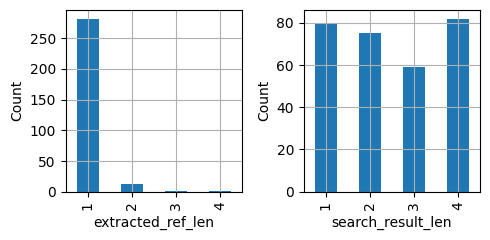

In [32]:
plot_lengths_by_type(df, 'mrc_question_with_1_to_4_negative')

- 이 데이터 타입은 검색 문서 개수가 1~4로 다양한 것을 보여주고 있음
- 인용한 문서는 대부분이 1개 문서를 사용한 것을 볼 수 있다

In [34]:
print('데이터의 유형:', df['type'].loc[787])
print('질문:', df['question'].loc[787])
print('답변:', df['answer'].loc[787])
print('인용 문서:', df['extracted_ref_numbers'].loc[787])

데이터의 유형: synthetic_question
질문: 한국전력 본사 부지 매각이 서울 강남 지역에 미칠 영향은 무엇인가요?
답변: 한국전력 본사 부지 매각이 서울 강남 지역에 미칠 영향은 여러 가지로 분석될 수 있습니다.

첫째, 한국전력 본사 부지는 서울 강남권의 마지막 대규모 개발 부지 중 하나로, 매각이 성사되면 대규모 개발 프로젝트가 진행될 가능성이 큽니다. 이는 강남 지역의 부동산 시장에 큰 영향을 미칠 수 있습니다. 예를 들어, 삼성전자와 현대자동차 등 대기업들이 이 부지에 관심을 보이고 있으며, 이들이 부지를 매입해 고층 빌딩이나 연구개발(R&D) 센터, 본사 등을 건설할 경우 강남 지역의 상업 및 업무 환경이 크게 변화할 수 있습니다 [[ref1]], [[ref3]], [[ref4]].

둘째, 부지 매각 후 개발이 진행되면 강남 지역의 부동산 가치가 상승할 가능성이 있습니다. 특히, 서울시가 이 부지를 일반상업지역으로 용도 변경할 계획이 있어, 용적률이 높아지면 더 많은 건물이 들어설 수 있게 됩니다. 이는 강남 지역의 상업적 가치를 더욱 높일 수 있습니다 [[ref4]].

셋째, 한국전력 본사 부지에는 지하 변전소가 있어, 이를 처리하는 문제도 중요한 변수로 작용할 것입니다. 변전소를 이전하거나 지하 더 깊은 곳으로 옮기는 등의 작업이 필요할 수 있으며, 이는 개발 비용에 반영될 것입니다. 이러한 기술적 문제들이 해결되면 개발 속도가 빨라질 수 있습니다 [[ref3]].

넷째, 부지 매각 방식이 공개 경쟁입찰로 결정됨에 따라, 매각 대금이 최대한 높아질 가능성이 있습니다. 이는 한국전력의 재무 상황 개선에도 긍정적인 영향을 미칠 수 있습니다 [[ref4]].

이와 같이 한국전력 본사 부지 매각은 강남 지역의 부동산 시장, 상업 환경, 그리고 한국전력의 재무 상황 등에 다양한 영향을 미칠 것으로 예상됩니다.
인용 문서: [1 3 4]


타입: synthetic_question
전체 데이터 수: 497개

문서 인용 분포:
1개의 문서를 인용한 샘플: 157개
2개의 문서를 인용한 샘플: 196개
3개의 문서를 인용한 샘플: 102개
4개의 문서를 인용한 샘플: 35개
5개의 문서를 인용한 샘플: 7개

검색된 문서 분포:
검색 문서로 5개가 존재하는 경우: 497개


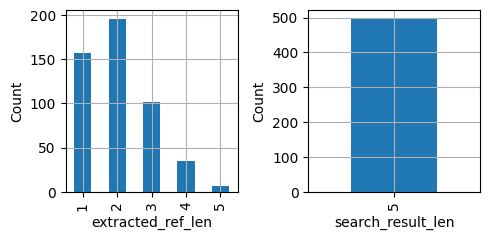

In [35]:
plot_lengths_by_type(df, 'synthetic_question')

포괄적인 질문 데이터라서 앞에 두가지 타입보다 2개 이상 문서를 인용하는 비율이 많음


In [37]:
print('데이터의 유형:', df['type'].loc[1289])
print('질문:', df['question'].loc[1289])

데이터의 유형: paraphrased_question
질문: 하워드 마셜의 재산 상속을 위해 안나 니콜 스미스가 법정 소송을 벌인 기간


타입: paraphrased_question
전체 데이터 수: 196개

문서 인용 분포:
1개의 문서를 인용한 샘플: 177개
2개의 문서를 인용한 샘플: 13개
3개의 문서를 인용한 샘플: 4개
4개의 문서를 인용한 샘플: 2개

검색된 문서 분포:
검색 문서로 5개가 존재하는 경우: 196개


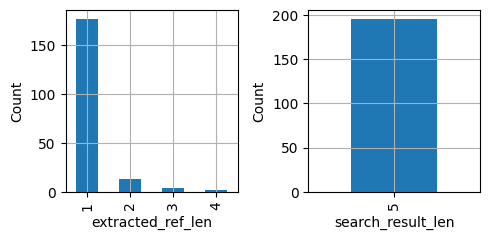

In [38]:
plot_lengths_by_type(df, 'paraphrased_question')

In [39]:
print('데이터의 유형:', df['type'].loc[1480])
print('질문:', df['question'].loc[1480])
print('답변:', df['answer'].loc[1480])
print('답변에서 인용한 문서:', df['extracted_ref_numbers'].loc[1480])

데이터의 유형: no_answer
질문: 원종 설립 당시 일본 정부의 반응은 어떠했나요?
답변: 검색 결과에는 원종 설립 당시 일본 정부의 반응을 찾을 수 없습니다.
답변에서 인용한 문서: []


질문들이 명사구로 끝나는 타입들의 경우도 마찬가지로 1개 문서 인용

타입: no_answer
전체 데이터 수: 404개

문서 인용 분포:
0개의 문서를 인용한 샘플: 404개

검색된 문서 분포:
검색 문서로 5개가 존재하는 경우: 404개


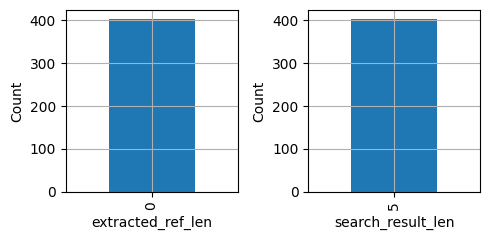

In [40]:
plot_lengths_by_type(df, 'no_answer')

검색하는 문서는 모두 5개지만 안에서 답이 없어 인용 문서 0개로 답변이 불가한 no_answer 타입이다

추가적인 궁금증
- 이 데이터의 type을 어떻게 분류하고 생성했는지